## Theory

An **autoencoder** is a type of **neural network** used mainly for **unsupervised learning**. It is designed to **encode** input data  and then **reconstruct** the original input from this compressed representation.

#### How It Works:

An autoencoder consists of two main parts:

- **Encoder:** Compresses the input data into a lower-dimensional representation (latent space).
- **Decoder:** Reconstructs the original input from this compressed representation.


## Implementation

### Library, Load Data, Transform Data

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
# restart the kernel and it works

In [3]:
# Gets input range [0,1]
transform = transforms.ToTensor()
# Converts the image from PIL format (0-255 pixel values) to a PyTorch tensor (0 to 1 normalized float values).
# This helps in training neural networks as deep learning models work better with normalized inputs.

# Gets input range [-1,1]
# transform = transforms.Compose(
#     transforms.ToTensor(),
#     transforms.Normalize((0.5), (0.5))
# )

mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

data_loader = torch.utils.data.DataLoader(dataset=mnist_data, batch_size=64, shuffle=True)

100%|██████████| 9.91M/9.91M [00:09<00:00, 1.05MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 103kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 851kB/s] 
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.66MB/s]


In [14]:
dataiter = iter(data_loader)
images, labels = next(dataiter)
print(torch.min(images), torch.max(images))
# As seen, the tensor values ranges from 0 and 1

tensor(0.) tensor(1.)


### Simple Autoencoder

In [21]:
class Autoencoder_Linear(nn.Module):
    def __init__(self):
        super().__init__()

        # In the beginneing image size: N, 784
        # Drastically reduce input image size
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128), # Linear Layer, reduce size from N, 784 -> N, 128
            nn.ReLU(), # Activation function
            nn.Linear(128, 64), # Linear Layer, reduce size from N, 128 -> N, 64
            nn.ReLU(),
            nn.Linear(64, 12), # Linear Layer, reduce size from N, 64 -> N, 12
            nn.ReLU(),
            nn.Linear(12, 3), # Linear Layer, reduce size from N, 12 -> N, 3
        )

        # Increase the output size to the original image size (oppostie of before)
        self.decoder = nn.Sequential(
            nn.Linear(3, 12), 
            nn.ReLU(),
            nn.Linear(12, 64), 
            nn.ReLU(),
            nn.Linear(64, 128), 
            nn.ReLU(),
            nn.Linear(128, 28*28), 
            nn.Sigmoid() # Activation function to get output between 0 and 1
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
# Note:
# Keep the Activation function of the last layer in mind
# Input image ranges:
#     [0,1] --> nn.Sigmoid()
#     [-1,1] --> nn.Tanh()

In [16]:
model = Autoencoder_Linear()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [17]:
# training
num_epochs = 10
outputs = []
for epoch in range(num_epochs):
    for (img, _) in data_loader:
        img = img.reshape(-1, 28*28)
        recon = model(img)
        loss = criterion(recon, img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch:{epoch+1}, Loss:{loss.item():.4f}")
    outputs.append((epoch, img, recon))

Epoch:1, Loss:0.0470
Epoch:2, Loss:0.0446
Epoch:3, Loss:0.0335
Epoch:4, Loss:0.0391
Epoch:5, Loss:0.0326
Epoch:6, Loss:0.0373
Epoch:7, Loss:0.0386
Epoch:8, Loss:0.0359
Epoch:9, Loss:0.0379
Epoch:10, Loss:0.0322


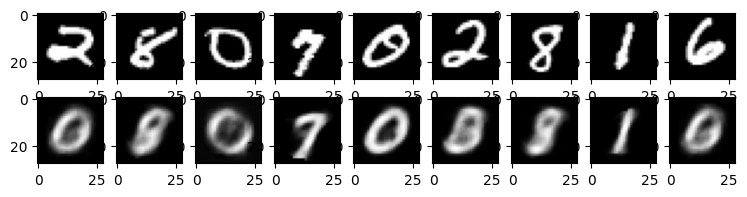

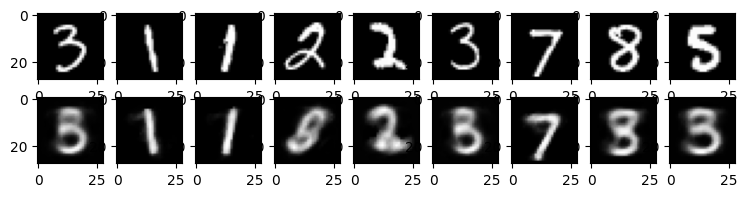

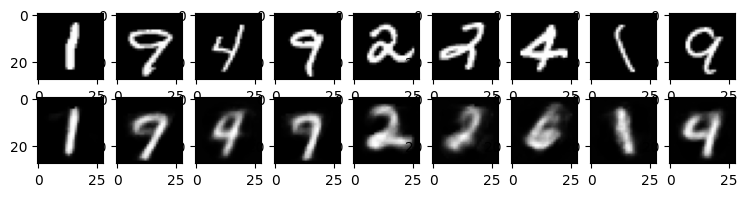

In [20]:
# plot image
for k in range(0, num_epochs, 4):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()
    for i, item in enumerate(imgs):
        if i>= 9: break
        plt.subplot(2, 9, i+1)
        item = item.reshape(-1, 28, 28)
        plt.imshow(item[0])

    for i, item in enumerate(recon):
        if i>= 9: break
        plt.subplot(2, 9, 9+i+1)
        item = item.reshape(-1, 28, 28)
        plt.imshow(item[0])

### CNN Autoencoder

In [22]:
class Autoencoder_CNN(nn.Module):
    def __init__(self):
        super().__init__()

        # In the beginneing image (input) size: N, 1, 28, 28
        # Drastically reduce input image size
        self.encoder = nn.Sequential(
            # Convolutional layer: input channel, output channel, kernel size, stride, padding
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # get Output size: N, 16, 14, 14 (reduce image size by 50%)
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # Output size: N, 32, 7, 7 
            nn.ReLU(),
            nn.Conv2d(32, 64, 7) # Output size: N, 64, 1, 1 (64 channels, 1 pixel)
        )

        # Increase the output size to the original image size (oppostie of before)
        # N, 64, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7), # N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # N, 1, 28, 28
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
# Note:
# A lot of times in CNN, we use nn.MaxPool2d --> nn.MaxUnpool2d

In [26]:
model = Autoencoder_CNN()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [27]:
# training
num_epochs = 10
outputs = []
for epoch in range(num_epochs):
    for (img, _) in data_loader:
        recon = model(img)
        loss = criterion(recon, img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch:{epoch+1}, Loss:{loss.item():.4f}")
    outputs.append((epoch, img, recon))

Epoch:1, Loss:0.0091
Epoch:2, Loss:0.0056
Epoch:3, Loss:0.0042
Epoch:4, Loss:0.0036
Epoch:5, Loss:0.0036
Epoch:6, Loss:0.0038
Epoch:7, Loss:0.0025
Epoch:8, Loss:0.0030
Epoch:9, Loss:0.0029
Epoch:10, Loss:0.0028


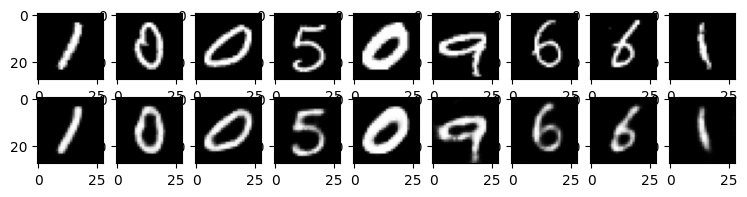

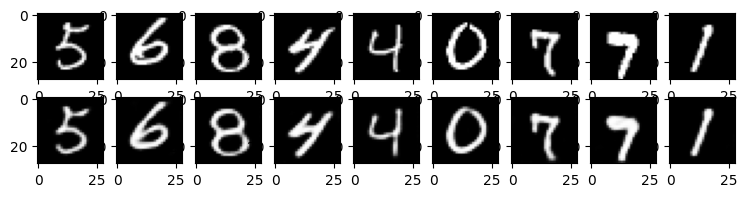

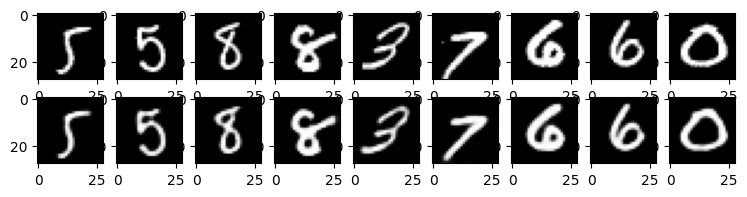

In [28]:
# plot image
for k in range(0, num_epochs, 4):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()
    for i, item in enumerate(imgs):
        if i>= 9: break
        plt.subplot(2, 9, i+1)
        plt.imshow(item[0])

    for i, item in enumerate(recon):
        if i>= 9: break
        plt.subplot(2, 9, 9+i+1)
        plt.imshow(item[0])